In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling & preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import joblib  # save models


In [6]:

file_path = "train.csv"  
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()


Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [7]:
# Basic info
df.info()

# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Credit_History      50
Self_Employed       32
LoanAmount          22
Dependents          15
Loan_Amount_Term    14
Gender              13
Married              3
dtype: int64

In [8]:
# NOTE: adjust target name if different (Loan_Status / Loan_Status)
# Show the column names so you'll know target name
print("Columns:", df.columns.tolist())

# Example target name on this dataset: 'Loan_Status' (Y/N)
# If your file uses a different column name, update below.
target_col = 'Loan_Status'  # change if needed

if target_col in df.columns:
    print("Target value counts:")
    display(df[target_col].value_counts())

# Summary statistics
display(df.describe())


Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']
Target value counts:


Loan_Status
Y    422
N    192
Name: count, dtype: int64

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


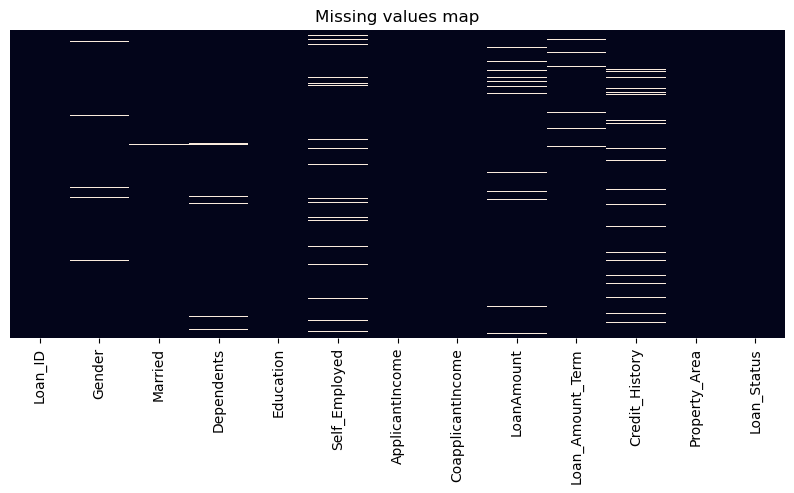

In [9]:
# Visual quick check of missing values (requires seaborn)
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Missing values map")
plt.show()


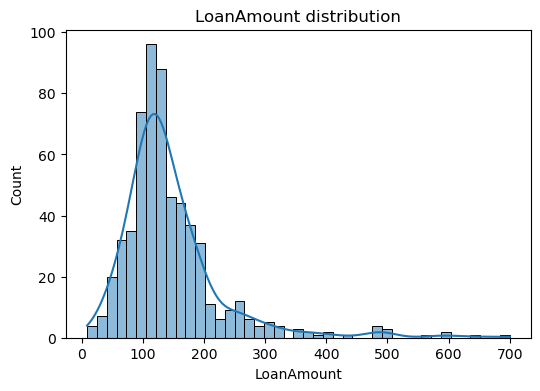

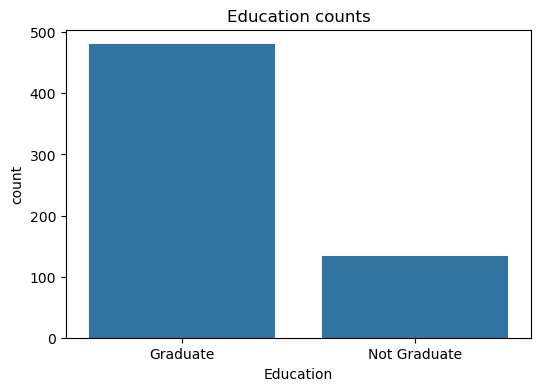

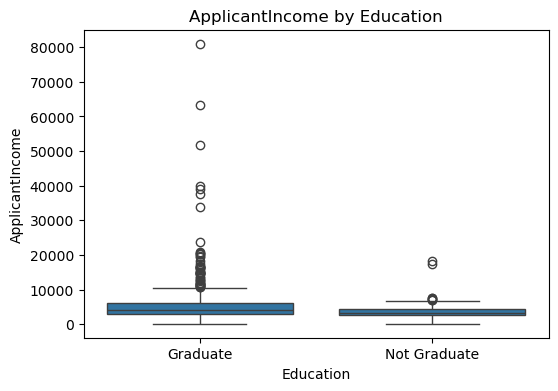

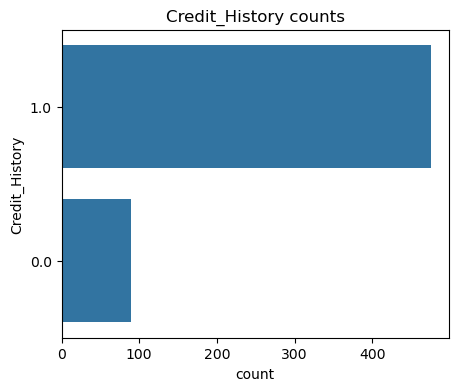

In [10]:
# Visuals for important features
plt.figure(figsize=(6,4))
sns.histplot(df['LoanAmount'].dropna(), kde=True)
plt.title('LoanAmount distribution')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Education', order=df['Education'].value_counts().index)
plt.title('Education counts')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='Education', y='ApplicantIncome')
plt.title('ApplicantIncome by Education')
plt.show()

if 'Credit_History' in df.columns:
    plt.figure(figsize=(5,4))
    sns.countplot(df['Credit_History'].dropna().astype(str))
    plt.title('Credit_History counts')
    plt.show()


In [11]:
# 1) Identify numeric and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target from features lists if present
if target_col in num_cols:
    num_cols.remove(target_col)
if target_col in cat_cols:
    cat_cols.remove(target_col)

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# 2) Imputation strategies
num_imputer = SimpleImputer(strategy='median')        # numeric -> median
cat_imputer = SimpleImputer(strategy='most_frequent') # categorical -> mode

# 3) Encoding for categorical variables - we'll label-encode binary / low-card features
# Prepare pipelines
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', num_imputer),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', cat_imputer),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])


Numeric cols: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical cols: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [12]:
# Map target to binary if necessary (Loan_Status: 'Y'/'N')
if target_col in df.columns:
    y = df[target_col].copy()
    if y.dtype == object:
        y = y.map({'Y':1, 'N':0})
else:
    raise ValueError(f"Target column '{target_col}' not found — update target_col variable.")

# Drop any ID-like columns (adjust column names as needed)
drop_cols = ['Loan_ID'] if 'Loan_ID' in df.columns else []
X = df.drop(columns=drop_cols + [target_col], errors='ignore')

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (614, 11) y shape: (614,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (491, 11) Test: (123, 11)


In [28]:
 # Build pipelines
pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

pipe_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

In [29]:
#   Train Logistic Regression
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# ROC-AUC for Logistic Regression
y_proba_lr = pipe_lr.predict_proba(X_test)[:,1]
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
print("Logistic Regression ROC-AUC:", roc_auc_lr)


Logistic Regression Accuracy: 0.8617886178861789
Confusion Matrix:
 [[22 16]
 [ 1 84]]
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123

Logistic Regression ROC-AUC: 0.8523219814241486


In [30]:
#  Train Decision Tree
pipe_dt.fit(X_train, y_train)
y_pred_dt = pipe_dt.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

y_proba_dt = pipe_dt.predict_proba(X_test)[:,1]
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
print("Decision Tree ROC-AUC:", roc_auc_dt)


Decision Tree Accuracy: 0.7560975609756098
Confusion Matrix:
 [[23 15]
 [15 70]]
              precision    recall  f1-score   support

           0       0.61      0.61      0.61        38
           1       0.82      0.82      0.82        85

    accuracy                           0.76       123
   macro avg       0.71      0.71      0.71       123
weighted avg       0.76      0.76      0.76       123

Decision Tree ROC-AUC: 0.7143962848297213


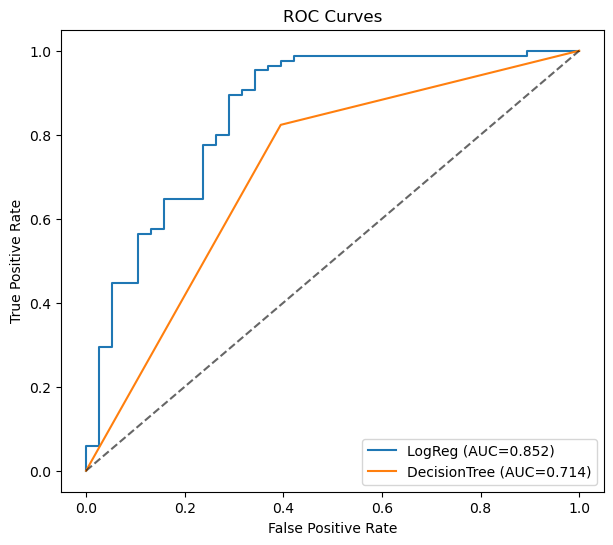

In [31]:
# Plot ROC curves
plt.figure(figsize=(7,6))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={roc_auc_lr:.3f})')

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.plot(fpr_dt, tpr_dt, label=f'DecisionTree (AUC={roc_auc_dt:.3f})')

plt.plot([0,1],[0,1],'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [32]:
#  Feature importance & coefficients
# Decision Tree importances
ohe = pipe_dt.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
try:
    onehot_feature_names = list(ohe.get_feature_names_out(cat_cols))
except:
    onehot_feature_names = []
feature_names = num_cols + onehot_feature_names

dt_clf = pipe_dt.named_steps['clf']
importances = dt_clf.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Top Decision Tree features:")
display(feat_imp.head(15))

# Logistic Regression coefficients
lr_clf = pipe_lr.named_steps['clf']
coefs = lr_clf.coef_[0]
coef_series = pd.Series(coefs, index=feature_names).sort_values(key=abs, ascending=False)
print("Top Logistic Regression coefficients:")
display(coef_series.head(15))

Top Decision Tree features:


Credit_History             0.261446
LoanAmount                 0.202923
ApplicantIncome            0.174145
CoapplicantIncome          0.137392
Property_Area_Semiurban    0.039786
Loan_Amount_Term           0.032932
Gender_Female              0.028731
Property_Area_Rural        0.021692
Education_Not Graduate     0.020435
Dependents_0               0.015167
Education_Graduate         0.012614
Property_Area_Urban        0.011826
Married_Yes                0.009776
Married_No                 0.008821
Dependents_3+              0.007096
dtype: float64

Top Logistic Regression coefficients:


Credit_History             1.247874
Property_Area_Semiurban    0.521915
Married_Yes                0.363831
Dependents_2               0.361337
Dependents_1              -0.342633
Education_Graduate         0.281449
Property_Area_Rural       -0.253183
Self_Employed_No           0.198821
Married_No                -0.190088
Gender_Female              0.175555
Dependents_3+              0.175407
CoapplicantIncome         -0.149221
Education_Not Graduate    -0.107707
Property_Area_Urban       -0.094990
LoanAmount                -0.042132
dtype: float64

In [33]:
#  Save models
joblib.dump(pipe_lr, 'loan_logistic_pipeline.joblib')
joblib.dump(pipe_dt, 'loan_decisiontree_pipeline.joblib')
print("Saved both pipelines successfully!")

Saved both pipelines successfully!
